In [1]:
import numpy as np
from matplotlib import font_manager, rc
import matplotlib.pyplot as plt
import os
import json
from konlpy.tag import Okt
import pymysql.cursors
import pandas as pd
import re

In [32]:
conn = pymysql.connect(host='localhost',
                       user='lyunj',
                       password='Dldbswo77@',
                       db='coupang_review',  # coupang_review 스키마 생성 필요
                       charset='utf8',
                       cursorclass=pymysql.cursors.DictCursor)
try:
    with conn.cursor() as curs:
        sql = 'select *,(pow(if(special_char_count = 0,1,special_char_count),2) + pow(if(manufacturer_count = 0,1,manufacturer_count),2) + pow(if(product_count = 0,1,product_count),2)) / if(review_len = 0, 1, review_len) as c1 from review_analyzing_data where review_len <> 0 and not isnull(review_score)'
        curs.execute(sql)
        result = curs.fetchall()
        df = pd.DataFrame(result)
finally:
    conn.close()

In [2]:
okt = Okt()

In [3]:
def tokenize(review):
    return ['/'.join(t) for t in okt.pos(review, norm=True, stem=True)]

In [79]:
import nltk

with open('review_token.json', encoding='utf-8') as f:
    review_token = json.load(f)

tokens = [t for d in review_token for t in d[0] if ((
    t.split('/')[1] == 'Noun') or (t.split('/')[1] == 'Adjective'))]

text = nltk.Text(tokens, name='NMSC')

print(len(set(text.tokens)))

34256


In [90]:
tokens_1 = [t for d in review_token for t in d[0] if (((
    t.split('/')[1] == 'Noun') or
    (t.split('/')[1] == 'Adjective')) and d[1] == '1')]

text_1 = nltk.Text(tokens_1, name='NMSC')

rating_1 = text_1.vocab().most_common(1000)

tokens_5 = [t for d in review_token for t in d[0] if (((
    t.split('/')[1] == 'Noun') or
    (t.split('/')[1] == 'Adjective')) and d[1] == '5')]
text_5 = nltk.Text(tokens_5, name='NMSC')

rating_5 = text_5.vocab().most_common(1000)

rating_1_word = [x[0] for x in rating_1]
rating_5_word = [x[0] for x in rating_5]

common_word = [x for x in rating_1_word if x in rating_5_word]

rating_1_word_not_common = [x for x in rating_1_word if x not in common_word]
rating_5_word_not_common = [x for x in rating_5_word if x not in common_word]

# tokens_1_word = [x for x in tokens_1 if x not in common_word]
# tokens_5_word = [x for x in tokens_5 if x not in common_word]

In [81]:
rating_1_count = []
for word,count in rating_1:
    if word in common_word:
        rating_1_count.append(count)
print(len(rating_1_count))

697


In [82]:
rating_5_count = []
for word,count in rating_5:
    if word in common_word:
        rating_5_count.append(count)
print(len(rating_5_count))

697


In [83]:
r = 19050/56990
rating_5_count = list(map(lambda x : x*r,rating_5_count))

In [84]:
r = 102.1/155.3
rating_5_count = list(map(lambda x : x*r,rating_5_count))

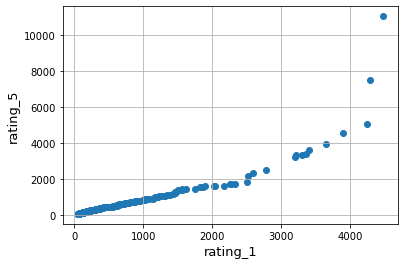

In [85]:
# 1점 리뷰에서 많이 쓰는 단어는 5점 리뷰에서도 많이 쓴다
plt.scatter(rating_1_count,rating_5_count)
plt.xlabel("rating_1", fontsize=13)
plt.ylabel("rating_5", fontsize=13)
plt.grid()
plt.show()

In [95]:
rating_5_df = df[df['review_rating'] == 5]
rating_1_df = df[df['review_rating'] == 1]

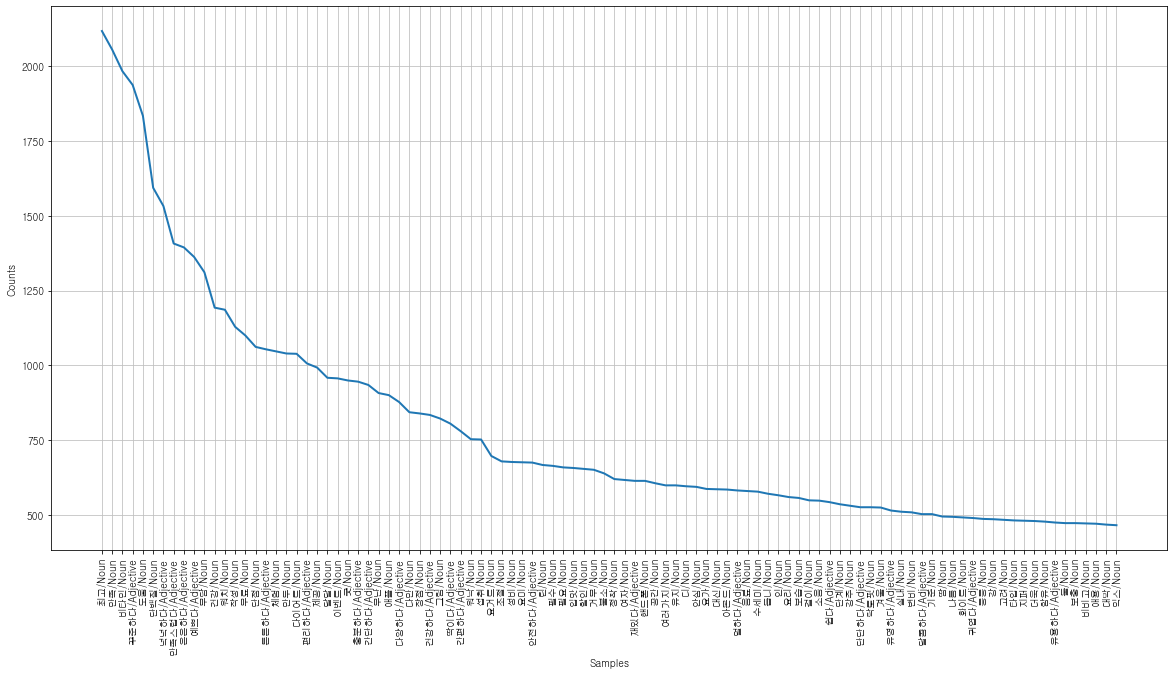

In [105]:
temp = [x for x in tokens_5 if x in rating_5_word_not_common]
font_fname = 'c:/windows/fonts/gulim.ttc'
font_name = font_manager.FontProperties(fname=font_fname).get_name()
rc('font', family=font_name)
plt.figure(figsize=(20, 10))
nltk.Text(temp).plot(100)

In [ ]:
for w,_,_ in review_token:
for word in rating_5_word_not_common[0:100]:
    result = []
    
        if()

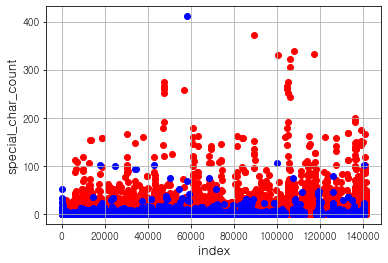

In [96]:
# 5점 리뷰와 1점 리뷰의 특수문자 개수
plt.scatter(rating_5_df.index,rating_5_df['special_char_count'],color='r')
plt.scatter(rating_1_df.index,rating_1_df['special_char_count'],color='b')
plt.xlabel("index", fontsize=13)
plt.ylabel("special_char_count", fontsize=13)
plt.grid()
plt.show()

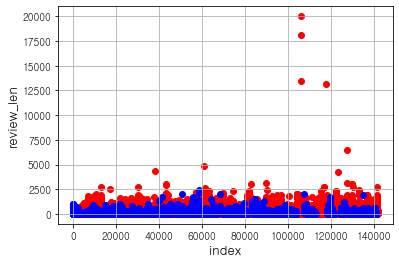

In [97]:
plt.scatter(rating_5_df.index,rating_5_df['review_len'],color='r')
plt.scatter(rating_1_df.index,rating_1_df['review_len'],color='b')
plt.xlabel("index", fontsize=13)
plt.ylabel("review_len", fontsize=13)
plt.grid()
plt.show()

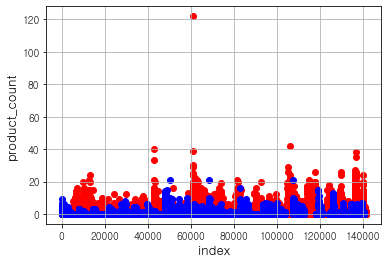

In [98]:
plt.scatter(rating_5_df.index,rating_5_df['product_count'],color='r')
plt.scatter(rating_1_df.index,rating_1_df['product_count'],color='b')
plt.xlabel("index", fontsize=13)
plt.ylabel("product_count", fontsize=13)
plt.grid()
plt.show()

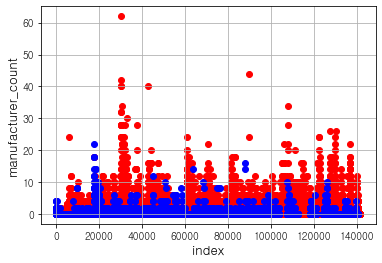

In [99]:
plt.scatter(rating_5_df.index,rating_5_df['manufacturer_count'],color='r')
plt.scatter(rating_1_df.index,rating_1_df['manufacturer_count'],color='b')
plt.xlabel("index", fontsize=13)
plt.ylabel("manufacturer_count", fontsize=13)
plt.grid()
plt.show()

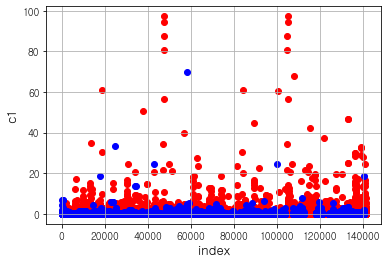

In [100]:
plt.scatter(rating_5_df.index,rating_5_df['c1'],color='r')
plt.scatter(rating_1_df.index,rating_1_df['c1'],color='b')
plt.xlabel("index", fontsize=13)
plt.ylabel("c1", fontsize=13)
plt.grid()
plt.show()